In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from models.crnn import CRNN
from models.convlstm import Conv1DLSTM
from models.convlstm_fcn_all import Conv1DLSTM_All

from utils.train_utils import train, EarlyStopping, load_checkpoint, count_parameters, epoch_time
from utils.test_utils import evaluate
from utils.visualization import get_predictions, plot_confusion_matrix


import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import random
import time

In [2]:
SEED = 37

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Dataset Loader

In [3]:
ROOT =  "/home/yi/Desktop/momask-codes/signal_processing/fig/"
data_dir = os.path.join(ROOT, 'sim')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

pretrained_size = 224
pretrained_means = [0.0239, 0.0350, 0.4974]
pretrained_stds= [0.1347, 0.1664, 0.0864]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])
test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)
test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

## Model

In [4]:
model = models.resnet18()
IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
model.fc = fc
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,180,616 trainable parameters


## Hyper Parameters for Training

In [6]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

EPOCHS = 100

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.1, patience = 10, verbose = True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

### Start Training

In [60]:
checkpoint_path = 'resnet_checkpoint.pth'
model_path = 'resnet_model.pth'
best_valid_loss = float('inf')
early_stopping = EarlyStopping(patience=10)

continue_flag = False
if continue_flag:
    model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path)
    
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)
        
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:6.2f}%')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:6.2f}%')
    
    torch.save({'epoch': epoch, 
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                 checkpoint_path)
    
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch+1:02}")
        break

Epoch: 01 | Epoch Time: 0m 32s
	Train Loss: 0.068 | Train Acc:  97.81%
	Valid Loss: 1.025 | Valid Acc:  76.07%
	Test Loss: 0.981 | Test Acc:  75.58%
Epoch: 02 | Epoch Time: 0m 32s
	Train Loss: 0.107 | Train Acc:  96.27%
	Valid Loss: 1.474 | Valid Acc:  68.73%
	Test Loss: 1.693 | Test Acc:  68.61%
INFO: Early stopping counter 1 of 10
Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 0.051 | Train Acc:  98.39%
	Valid Loss: 1.270 | Valid Acc:  72.51%
	Test Loss: 1.307 | Test Acc:  73.75%
INFO: Early stopping counter 2 of 10
Epoch: 04 | Epoch Time: 0m 32s
	Train Loss: 0.066 | Train Acc:  97.70%
	Valid Loss: 1.005 | Valid Acc:  76.79%
	Test Loss: 1.087 | Test Acc:  77.10%
Epoch: 05 | Epoch Time: 0m 33s
	Train Loss: 0.035 | Train Acc:  98.80%
	Valid Loss: 0.551 | Valid Acc:  84.33%
	Test Loss: 0.752 | Test Acc:  83.55%
Epoch: 06 | Epoch Time: 0m 33s
	Train Loss: 0.024 | Train Acc:  99.42%
	Valid Loss: 1.376 | Valid Acc:  71.59%
	Test Loss: 1.447 | Test Acc:  71.05%
INFO: Early stopping counter 1 o

### Evaluation

In [7]:
model_path = 'resnet_model.pth'

model.load_state_dict(torch.load(model_path))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc*100:6.2f}% ')

Test Loss: 0.469 | Test Acc @1:  91.26% 


In [62]:
images, labels, probs = get_predictions(model, test_iterator, device)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)
classes = test_data.classes

In [63]:
from utils.visualization import plot_confusion_matrix

In [67]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes, save_path=None):
    fig = plt.figure(figsize = (7, 7));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels, normalize='pred');
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = '.2f', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 10)
    plt.ylabel('True Label', fontsize = 10)
    if save_path is not None:
        plt.savefig(save_path, dpi=500)

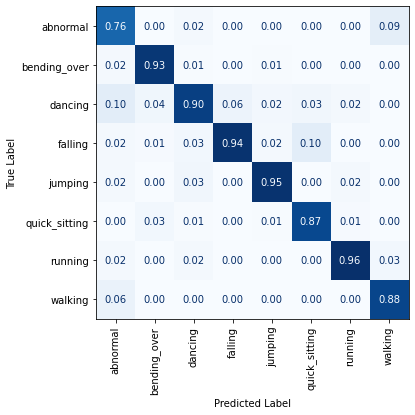

In [68]:
plot_confusion_matrix(labels, pred_labels, classes, 'resnet.png')

# Linear Probing

In [ ]:
model.load_state_dict(torch.load(model_path))
# Freeze all the layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)  # Assuming num_classes is defined

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Fine Tuning

In [ ]:
model.load_state_dict(torch.load(model_path))
# Optionally freeze the layers except the final layer
for param in model.parameters():
    param.requires_grad = False

# Make sure the last layer is unfrozen to fine-tune it
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace the last layer
for param in model.fc.parameters():
    param.requires_grad = True

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
# Fine-tune all parameters
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)